# DL models Cross-validation 및 시각화

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap
import pandas as pd
from tqdm import tqdm
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "7"

def set_seed(seed):
    # Set the random seed for PyTorch on CPU and GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed for Python's built-in random module
    random.seed(seed)
    
seed = 300
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(self.relu2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [3]:
# MLP 모델 정의
class MLP_1layer(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP_1layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed)   # always same test set
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]


# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control을 CKD와 어떤 비율로 뽑을지.
    """
    rng = np.random.default_rng(seed = seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size= len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    assert set(sampled_control_idx).issubset(set(control_idx))
    
    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def oversampling(unbalanced_dataframe, seed):
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

def normalizing(X_train, X_valid, X_test):
    # pd.Dataframe -> pd.Dataframe
    columns = X_train.columns
    
    wei_train_scaler = StandardScaler()
    # wei_train_scaler =MinMaxScaler()
    X_train_scaled = wei_train_scaler.fit_transform(X_train)
    X_valid_scaled = wei_train_scaler.transform(X_valid)
    X_test_scaled = wei_train_scaler.transform(X_test)
    
    # X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
    # X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns, index=X_valid.index)
    # X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns, index=X_test.index)
    
    return X_train_scaled, X_valid_scaled, X_test_scaled

In [5]:
# data = pd.read_csv("/home/user18/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_food_adjusted_mean.csv")
data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_only.csv")

In [6]:
data['CT1_SEX']

0        2
1        2
2        2
3        2
4        2
        ..
57226    2
57227    1
57228    2
57229    2
57230    2
Name: CT1_SEX, Length: 57231, dtype: int64

In [59]:
X_train, y_train = undersampling(data, seed=seed)
X_train_scaled, X_train_scaled, X_train_scaled = normalizing(X_train, X_train, X_train)

X_train_scaled = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)

X_train_scaled = X_train_scaled.cuda()
y_train = y_train.cuda()

In [60]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

def metric(y_test, y_pred):  # label, pred
    y_test = y_test.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred.flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate recall, precision, accuracy
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate AUC of ROC
    auc = roc_auc_score(y_test, y_pred)
    
    # Return all metrics
    return recall, precision, accuracy, auc

In [61]:
def train(model, optimizer, criterion, epoch, train_loader, l1_lambda=0.1):
    t = time.time()
    model.train()
    for train_input, train_label in train_loader:
        train_input = train_input.cuda(device)
        train_label = train_label.cuda(device)
        optimizer.zero_grad()
        
        # breakpoint()
        output = model(train_input)
        loss_train = criterion(output.squeeze(), train_label)
            
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())    # l1 norm
            loss_train += l1_lambda * l1_norm
    
        recall_train, precision_train, acc_train, auc_train = metric(train_label, output)
        loss_train.backward()
        optimizer.step()
    
    print("epoch : {:04d}, loss_train: {:.4f}, recall_train: {:.4f}, precision_train: {:.4f}, acc_train: {:.4f}, auc_train: {:.4f}, time: {:.4f}s".format(
        epoch+1, loss_train.item(), recall_train.item(), precision_train.item(), acc_train.item(), auc_train.item(), time.time() - t
    ))
      
    # print("Train results ==> epoch : {:04d}, loss_train: {:.4f}, acc_train: {:.4f}, time: {:.4f}s".format(
    #     epoch+1, loss_train.item(), acc_train.item(), time.time() - t
    # ))

In [62]:
def test_CV(model, criterion, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 이동
        # X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        # y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        X_test_tensor = X_test.to(device)
        y_test_tensor = y_test.to(device)
        
        # 모델 예측
        output_test = model(X_test_tensor)
        
        loss_test = criterion(output_test.squeeze(), y_test_tensor)
        
        # # 예측 결과 평가 (예측값을 0.5로 이진 분류)
        # total_label = y_test_tensor.cpu().detach().numpy()
        # total_pred = output_test.cpu().detach().numpy()
        
        # 정확도, 재현율, 정밀도, AUC 등의 메트릭 계산
        recall_test, precision_test, acc_test, auc_test = metric(y_test_tensor, output_test)
        
        # 결과 로그 출력
        # logger.info("Test set results")
        print("Test set results ==> loss= {:.4f}, recall= {:.4f}, precision= {:.4f}, accuracy= {:.4f}, AUC= {:.4f}".format(
            loss_test.item(), recall_test, precision_test, acc_test, auc_test))
        output_test = output_test.cpu().detach()
        
        return output_test, loss_test.item(), recall_test, precision_test, acc_test, auc_test

In [63]:
from sklearn.model_selection import KFold

def cross_validate(model_class, criterion, X_train_scaled, y_train, hidden1, hidden2=4):
    # KFold 객체 생성 (n_splits = 폴드 수)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)

    # 데이터셋에서 입력과 라벨을 분리
    X = X_train_scaled
    y = y_train

    fold_losses, fold_recalls, fold_precisions, fold_accuracies, fold_aucs = [], [], [], [], []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f'Fold {fold+1}')

        # 학습 데이터와 검증 데이터 분리
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        print(f"Train : {X_train.shape}, Test : {X_val.shape}")
        print(f"Train : {y_train.shape}, Test : {y_val.shape}")

        # 데이터로더를 각 폴드마다 생성
        # trainset = TabularDataset(X_train_scaled , y_train)
        # testset = TabularDataset(X_test_scaled , y_test)
        # train_loader = DataLoader(trainset, batch_size=1000, shuffle=True)
        # valid_loader = DataLoader(testset, batch_size=1000, shuffle=False)
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=1000, shuffle=True)
        valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=1000, shuffle=False)

        # 모델 초기화
        if model_class == MLP:
            model = MLP(input_size=X_train.shape[1], hidden_size1=hidden1, hidden_size2=hidden2, output_size=1).to(device)
        elif model_class == MLP_1layer:
            model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=hidden1, output_size=1).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        criterion = nn.BCELoss()
        
        # 학습
        for epoch in range(200):
            train(model, optimizer, criterion, epoch, train_loader)

        # 검증
        _, loss_val, recall_val, precision_val, acc_val, roc_val = test_CV(model, criterion, X_val, y_val)
        fold_losses.append(loss_val)
        fold_recalls.append(recall_val)
        fold_precisions.append(precision_val)
        fold_accuracies.append(acc_val)
        fold_aucs.append(roc_val)
        
        print(f"Fold {fold+1} Validation results")
        print(f"Loss, Recall, Precision, ACC, ROC:")
        print(f"{loss_val:.4f}, {recall_val:.4f}, {precision_val:.4f}, {acc_val:.4f}, {roc_val:.4f}")
        

    # 전체 폴드의 평균 정확도 출력
    mean_fold_loss, std_fold_loss = np.mean(fold_losses), np.std(fold_losses)
    mean_fold_recall, std_fold_recall = np.mean(fold_recalls), np.std(fold_recalls)
    mean_fold_pricision, std_fold_precision = np.mean(fold_precisions), np.std(fold_precisions)
    mean_fold_accuracy, std_fold_accuracy = np.mean(fold_accuracies), np.std(fold_accuracies)
    mean_fold_auc, std_fold_auc = np.mean(fold_aucs), np.std(fold_aucs)
    print('!!! Cross-Validation Mean Accuracy !!!')
    print(f'loss  /  recall  /  precision  /  ACC  /  ROC  ')
    print(f'MEAN :: {mean_fold_loss:.4f}, {mean_fold_recall:.4f}, {mean_fold_pricision:.4f}, {mean_fold_accuracy:.4f}, {mean_fold_auc:.4f}')
    print(f'STD :: {std_fold_loss:.4f}, {std_fold_recall:.4f}, {std_fold_precision:.4f}, {std_fold_accuracy:.4f}, {std_fold_auc:.4f}')
    
    return model

In [64]:
# model = MLP(input_size=X_train.shape[1], hidden_size1=16, hidden_size2=4, output_size=1).to(device)
# model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=8, output_size=1).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.BCELoss()
hidden1 = 64

# cross_validate(MLP_1layer, criterion, X_train_scaled, y_train, hidden1)
trained_model = cross_validate(MLP, criterion, X_train_scaled, y_train, hidden1, hidden2=16)

Fold 1
Train : torch.Size([945, 21]), Test : torch.Size([105, 21])
Train : torch.Size([945]), Test : torch.Size([105])
epoch : 0001, loss_train: 30.6083, recall_train: 0.5127, precision_train: 0.4691, acc_train: 0.4646, auc_train: 0.4644, time: 0.0172s
epoch : 0002, loss_train: 30.3715, recall_train: 0.5781, precision_train: 0.4973, acc_train: 0.4952, auc_train: 0.4950, time: 0.0141s
epoch : 0003, loss_train: 30.1218, recall_train: 0.5084, precision_train: 0.4801, acc_train: 0.4772, auc_train: 0.4771, time: 0.0136s
epoch : 0004, loss_train: 29.8533, recall_train: 0.5380, precision_train: 0.4848, acc_train: 0.4815, auc_train: 0.4813, time: 0.0135s
epoch : 0005, loss_train: 29.6236, recall_train: 0.5084, precision_train: 0.4801, acc_train: 0.4772, auc_train: 0.4771, time: 0.0138s
epoch : 0006, loss_train: 29.3582, recall_train: 0.5506, precision_train: 0.4824, acc_train: 0.4783, auc_train: 0.4781, time: 0.0135s
epoch : 0007, loss_train: 29.1199, recall_train: 0.5232, precision_train: 0.4

F_1, 2, 4, 16, 5, 10, 13, 16_res_mean 

# Shap visualization

In [65]:
X_train

,F01_Mean_res,F02_Mean_res,F03_Mean_res,F04_Mean_res,F05_Mean_res,F06_Mean_res,F07_Mean_res,F08_Mean_res,F09_Mean_res,F10_Mean_res,...,F12_Mean_res,F13_Mean_res,F14_Mean_res,F15_Mean_res,F16_Mean_res,F17_Mean_res,F18_Mean_res,F19_Mean_res,F20_Mean_res,F21_Mean_res
16569,167.157602,-95.183085,-11.946641,-2.825211,5.187212,0.427747,3.306953,-7.565060,-1.539630,-2.532301,...,-0.555913,-10.178114,-0.853610,-1.698526,-1.605569,2.161429,0.923434,-19.187511,-10.789104,-25.148294
36117,-37.563345,43.593004,-9.780530,-0.233712,-5.260810,-1.036939,-1.560014,-8.117495,-1.634999,-3.010847,...,-4.061161,-9.809348,-3.204046,-2.249426,-2.777832,-0.005969,-0.286933,-27.008507,-2.160091,-28.446049
30472,159.034784,-90.772268,-15.267598,-3.863762,1.400161,-0.820658,-1.389250,-7.569438,-1.194011,-0.912314,...,2.363764,-2.554084,11.993552,18.377774,-3.206589,1.253571,-0.482252,-20.529876,-19.431732,-33.136374
24693,-28.860722,37.610095,9.259623,1.206837,1.152510,-0.364308,3.166715,3.725814,-1.500384,0.112292,...,9.813991,-16.875925,-1.037623,-4.092638,-1.085677,-1.031081,0.360608,-25.465172,-16.509408,-26.746388
16021,-28.906008,36.811572,-9.468159,-1.699718,-1.754398,-1.134643,-2.057209,-6.784429,1.650678,-0.828465,...,14.153609,5.017835,-3.161398,-3.813959,-7.342932,0.515817,1.891131,-26.040212,-9.368330,3.361854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56767,204.764304,-102.100031,-4.383767,-0.090700,0.402803,1.270190,-2.751432,-10.732733,1.127132,-1.910726,...,-3.686132,-16.129076,-1.983045,1.042406,-9.015178,-0.798282,-0.404882,-21.861384,7.972865,-11.104520
56831,-52.307765,32.202243,-13.061931,0.433998,-1.880612,-2.139139,-2.123353,-7.252825,-1.329207,-3.421473,...,-1.459140,-12.803583,-4.898108,-3.942723,-11.099383,0.735724,-0.591261,-20.127381,-16.578934,-29.395724
56981,-23.834305,31.536434,-6.079665,-1.737769,-3.279602,-1.389792,-2.563709,-10.729722,-1.888922,4.279408,...,-3.856278,39.090362,-3.187051,-2.190251,-9.664802,-1.169793,-0.397388,-25.760502,-7.983900,-19.387925
57140,171.714100,-103.131863,-11.720011,-1.715636,-4.140477,0.423810,0.165900,-10.438789,-1.414106,-1.302172,...,-2.889723,-6.541972,-2.829095,-3.200475,-10.029317,-1.832142,0.420533,-18.000511,-14.316864,-24.594292


In [66]:
X_train_scaled

tensor([[ 2.0247, -1.6396, -0.9299,  ..., -0.6736, -0.2973, -0.5836],
        [-0.4817,  0.8308, -0.7571,  ..., -0.9508, -0.0445, -0.6658],
        [ 1.9252, -1.5610, -1.1947,  ..., -0.7212, -0.5506, -0.7825],
        ...,
        [-0.3137,  0.6162, -0.4620,  ..., -0.9066, -0.2151, -0.4402],
        [ 2.0805, -1.7810, -0.9118,  ..., -0.6316, -0.4007, -0.5699],
        [-0.5511,  0.5789,  2.3772,  ...,  0.8167, -0.3604, -0.4866]],
       device='cuda:0')

In [67]:
explainer_shap = shap.DeepExplainer(trained_model, X_train_scaled)
shap_values = explainer_shap.shap_values(X_train_scaled, check_additivity=False)

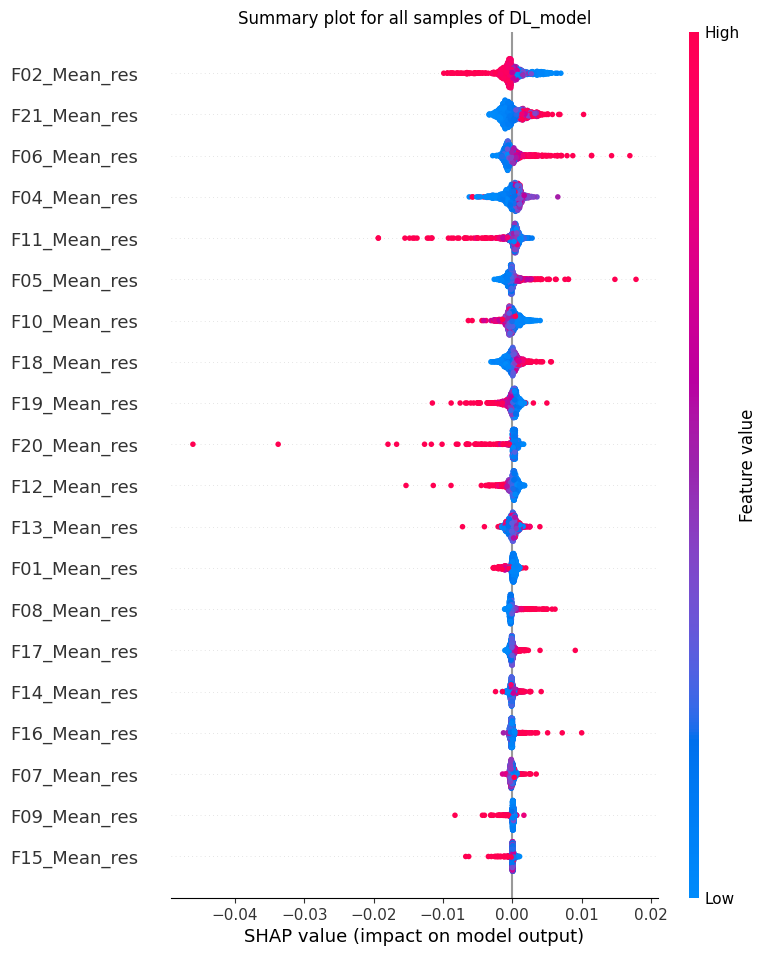

In [68]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns.tolist(), show=False)
plt.title(f"Summary plot for all samples of DL_model")
plt.show()

## Summary plot

In [ ]:
# 색깔이 의미하는 것은 특성 값의 크기이다.
# X축 (shap value)의 값이 크면 모델의 예측을 증가시킨다는 의미이다.
# 예를 들어, CT1_eGFR이 작은 샘플(파란색)에 대해서 shap value가 크고, CT1_eGFR이 큰 샘플(빨간색)에 대해서 shap value가 작은 걸 보면
# eGFR이 작으면 모델의 예측값을 키우고, eGFR이 크면 모델의 예측값을 작게 한다. => 모델의 예측은 키우면 CKD로 분류, 줄이면 Control로 분류.

plt.figure()
shap.summary_plot(shap_values, X_test.values, feature_names=X_train.columns.tolist(),       # X_test 자리에 (ndarray)를 넣어야 색깔이 나옴.
                  cmap='bwr', show=False)
plt.title("Summary plot for basic & food adjusted mean")
plt.show()

In [ ]:
total_train = pd.merge(X_train, pd.DataFrame(y_train), left_index=True, right_index=True)

# Boxplot을 사용하여 "onset_tight" 별로 "CT1_eGFR" 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='onset_tight', y='CT1_eGFR', data=total_train)

# 그래프 제목과 축 레이블 설정
plt.title('CT1_eGFR Distribution by onset_tight', fontsize=15)
plt.xlabel('onset_tight', fontsize=12)
plt.ylabel('CT1_eGFR', fontsize=12)

# 그래프 표시
plt.show()

## Decision plot

### decision plot by ((CKD or Control samples) & (CKD or Control outputs))

- ex) ckd sample이 모델이 ckd output을 내는 데에 얼마나 기여했는지를 의미하는 shap_value

In [ ]:
outputs.shape

In [ ]:
outputs_of_ckd, outputs_of_control = outputs[:52], outputs[52:]

### For CKD test sample

In [ ]:
plt.figure()
# 아래 그림에서 위부분의 결과값은 model output을 의미한다.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,    # model output들의 평균. (여기서는 c=0이라서 control output들의 평균이다.)
                   shap_values[ckd_idx],    # shape : (5, 34)
                   X_test.values[ckd_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title("Shap plot for CKD Samples")
plt.show()

In [ ]:
(outputs_of_ckd < 0.5)

In [ ]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n = 22
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

In [ ]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n =11
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

### For Control sample

For control output

In [ ]:
plt.figure()
# control sample이 ckd ( c=0 )쪽을 담당하는 output에 얼마나 기여를 했는지에 대한 shap_value를 시각화.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[control_idx],    # shape : (5, 34)
                   X_test.values[control_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for Control Samples")
plt.show()

In [ ]:
(outputs_of_control > 0.5)

In [ ]:
outputs_of_control[(outputs_of_control > 0.5)]

In [ ]:
# one control sample, Control로 잘 예측함.

plt.figure()
n = 66
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

In [ ]:
# one control sample, for control output

plt.figure()
n = 75
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

### Error samples 확인

In [ ]:
# 전체 틀린 갯수
(outputs_of_ckd < 0.5).sum().item() + (outputs_of_control > 0.5).sum().item()

In [ ]:
error_ckd = (outputs_of_ckd < 0.5).view(-1)
error_control = (outputs_of_control > 0.5).view(-1)
error_idx = torch.cat((error_ckd, error_control), dim=0)        # .view(-1, 1)

In [ ]:
total_test = pd.merge(X_test, pd.DataFrame(y_test), left_index=True, right_index=True)

In [ ]:
total_test

In [ ]:
error_testsamples = total_test[error_idx.numpy()]

In [ ]:
error_testsamples

In [ ]:
correct_testsamples = total_test[~error_idx.numpy()]

In [ ]:
correct_testsamples